In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# Set the root path as if it's being ran from the project root
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

In [38]:
import pygad
import numpy as np
import torch
import os
from ga.fitness import constrained_fitness_func
from ga.model import load_model, evaluate_without_perturbation, evaluate_with_perturbation
from ga.utils import get_dataloader, visualize_images_batch,visualize_image, visualize_perturbation, compute_pixel_statistics, load_config

# Parameters

In [ ]:
config = load_config()

In [42]:
num_generations =num_generations=config["ga"]["num_generations"]
num_parents_mating=config["ga"]["num_parents_mating"]
sol_per_pop=config["ga"]["sol_per_pop"]
init_range_low=config["ga"]["init_range_low"]
init_range_high=config["ga"]["init_range_high"]
mutation_percent_genes=config["ga"]["mutation_percent_genes"]

model_type = config["model"]["model_type"]
batch_size = config["model"]["batch_size"]

visualize = config["visualization"]["visualize"]
visualize_every = config["visualization"]["visualize_every"]


# Model

In [6]:
model = load_model(config["model"]["model_type"])

# Loading

In [12]:
# Load
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
image_dir = os.path.join(project_root, "nn/data/imagenet/val")
dataloader = get_dataloader(config["model"]["batch_size"], image_dir)


In [14]:
# Compute the pixel mean and standard deviation for each pixel across the entire dataset - for constrained fitness func
pixel_mean, pixel_std = compute_pixel_statistics(dataloader)

In [16]:
# First batch
input_batch, original_labels = next(iter(dataloader))

# Collect top perturbations from each generation
top_perturbations = []

# GA Config

In [17]:
def fitness_wrapper(ga_instance, solution, solution_idx):
    return constrained_fitness_func(
        ga_instance, solution, solution_idx, pixel_std, model, input_batch, original_labels
    )

In [43]:
def on_generation(ga_instance):

    print(f"\nGeneration {ga_instance.generations_completed} completed with fitness: {ga_instance.last_generation_fitness}")

    input_batch, original_labels = next(iter(dataloader))
    print(f"New batch loaded with first label: {original_labels[0]}")
    
    # Print the best fitness for this generation
    best_solution, best_solution_fitness, _ = ga_instance.best_solution()
    print(f"Best Fitness = {best_solution_fitness}\n")

    best_perturbation = torch.tensor(best_solution).float().reshape(input_batch.shape[1:])
    top_perturbations.append(best_perturbation)
    print(f"Best perturbation magnitude: {torch.norm(best_perturbation).item()}")

    ########
    # VISUALIZATION
    ########
    if config["visualization"]["visualize"] and ga_instance.generations_completed % config["visualization"]["visualize_every"] == 0:
        print(f"Visualizing")
        # get the current best perturbation
        visualize_images_batch(input_batch, best_perturbation)

    # print(f"Generation {ga_instance.generations_completed}: Current Fitness: Best Fitness = {ga_instance.best_solution()[1]}")

/Users/OAA/miniforge3/envs/DL/lib/python3.8/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")



Generation 1 completed with fitness: [0.65625  0.65625  0.671875 0.65625  0.65625  0.65625  0.65625  0.65625
 0.640625 0.65625  0.65625  0.625    0.6875   0.640625 0.671875 0.640625
 0.65625  0.640625 0.65625  0.6875  ]
New batch loaded with first label: 695
Best Fitness = 0.6875

Best perturbation magnitude: 74.70710754394531
Visualizing


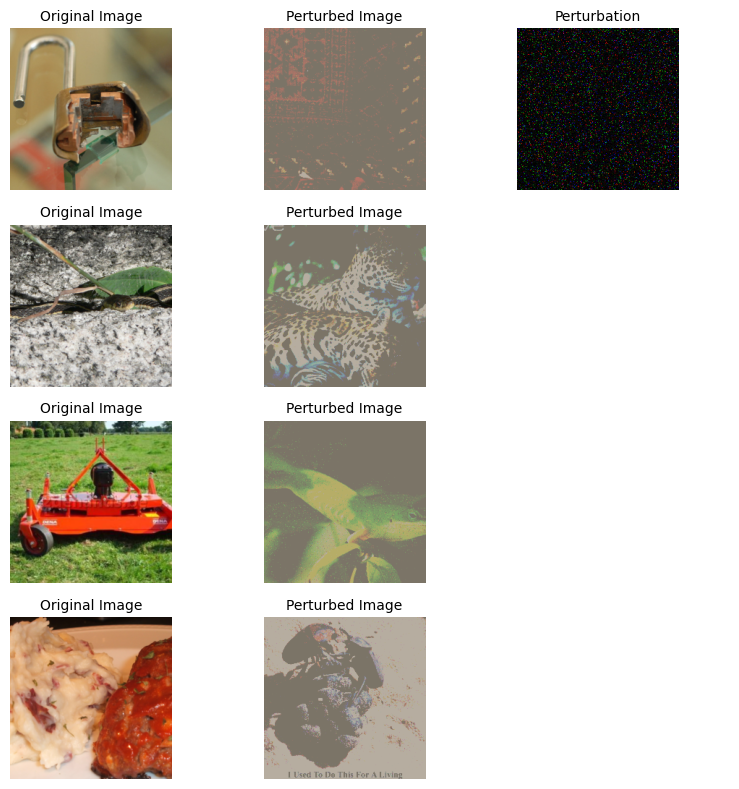


Generation 2 completed with fitness: [0.6875   0.703125 0.671875 0.6875   0.6875   0.6875   0.6875   0.640625
 0.6875   0.671875 0.671875 0.703125 0.6875   0.703125 0.703125 0.65625
 0.65625  0.671875 0.734375 0.65625 ]
New batch loaded with first label: 314
Best Fitness = 0.734375

Best perturbation magnitude: 102.23747253417969
Visualizing


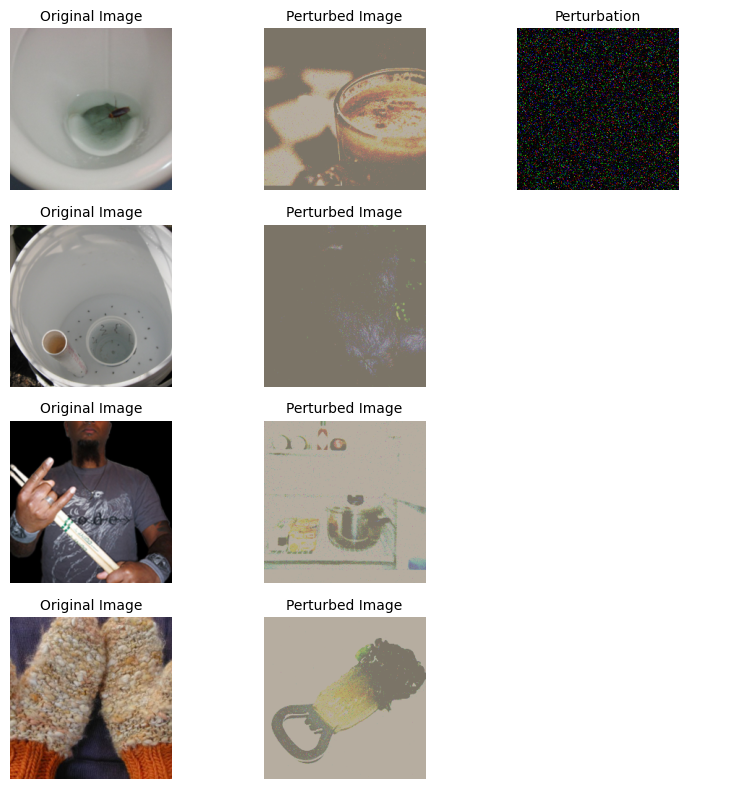


Generation 3 completed with fitness: [0.734375 0.75     0.703125 0.6875   0.703125 0.703125 0.71875  0.671875
 0.703125 0.703125 0.734375 0.6875   0.71875  0.734375 0.6875   0.734375
 0.71875  0.734375 0.71875  0.6875  ]
New batch loaded with first label: 652
Best Fitness = 0.75

Best perturbation magnitude: 124.1110610961914
Visualizing


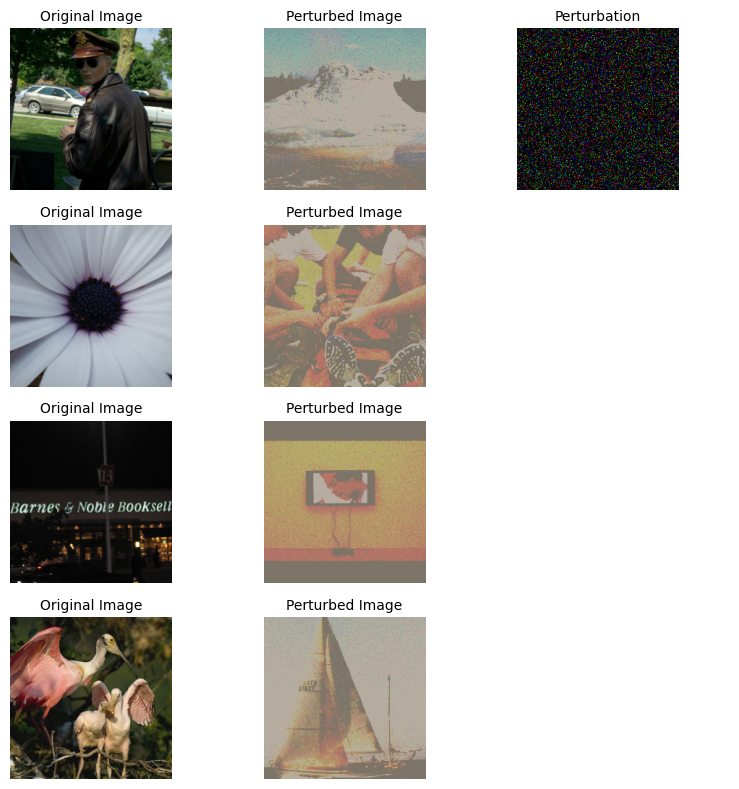


Generation 4 completed with fitness: [0.75     0.734375 0.71875  0.765625 0.75     0.703125 0.71875  0.734375
 0.734375 0.71875  0.71875  0.71875  0.71875  0.765625 0.78125  0.75
 0.75     0.78125  0.78125  0.765625]
New batch loaded with first label: 935
Best Fitness = 0.78125

Best perturbation magnitude: 143.78041076660156
Visualizing


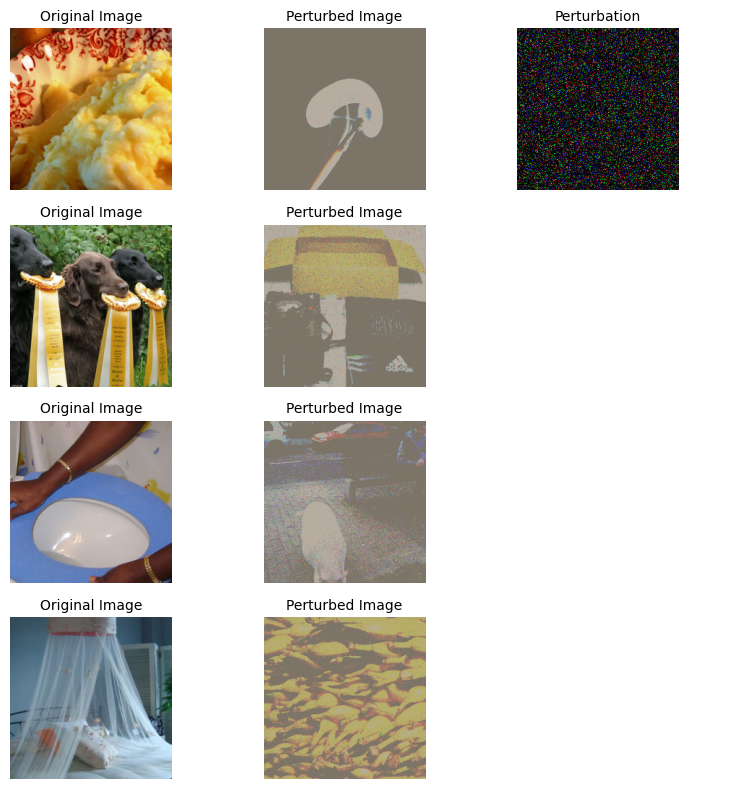


Generation 5 completed with fitness: [0.78125  0.765625 0.796875 0.71875  0.734375 0.75     0.75     0.765625
 0.75     0.75     0.796875 0.765625 0.78125  0.78125  0.765625 0.765625
 0.71875  0.78125  0.765625 0.703125]
New batch loaded with first label: 770
Best Fitness = 0.796875

Best perturbation magnitude: 160.4584197998047
Visualizing


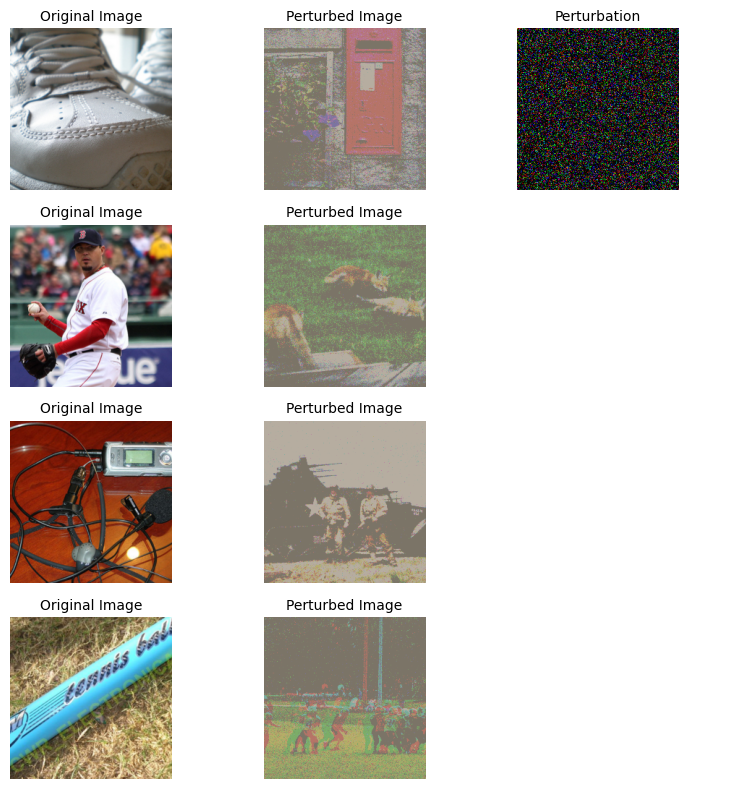

KeyboardInterrupt: 

In [44]:
ga_instance = pygad.GA(
    num_generations=config["ga"]["num_generations"],
    num_parents_mating=config["ga"]["num_parents_mating"],
    sol_per_pop=config["ga"]["sol_per_pop"],
    num_genes=3*224*224,
    gene_type=float,
    init_range_low=config["ga"]["init_range_low"],
    init_range_high=config["ga"]["init_range_high"],
    mutation_percent_genes=config["ga"]["mutation_percent_genes"],
    fitness_func=fitness_wrapper,
    on_generation=on_generation,
)

ga_instance.run()

In [29]:
input_batch.shape

torch.Size([64, 3, 224, 224])

In [22]:
# After the run
solution, solution_fitness, _ = ga_instance.best_solution()
print(f"Best solution fitness: {solution_fitness}") # Might be the penultimate best fitness??

Best solution fitness: 0.84375


# Calculating Universal Perturbation

In [25]:
if len(top_perturbations) > 0:
    universal_perturbation = torch.mean(torch.stack(top_perturbations), dim=0)
    print(universal_perturbation.shape)
    print(f"Universal perturbation created.")
    visualize_perturbation(universal_perturbation)

AttributeError: 'list' object has no attribute 'shape'

# Metrics

In [ ]:
evaluate_without_perturbation(model, dataloader, universal_perturbation)

In [ ]:
evaluate_with_perturbation(model, dataloader, universal_perturbation)